### Task 개요
#### MediaPipe Face Detection을 이용한 커스텀 Face Detection 모듈 개발
- 주피터 노트북 환경에서 MediaPipe Face Detection 파악
#### AI Hub에서
- K-Face 데이터로 성능확인
- 400명, 20개 카메라 방향
- 성능 98% 이상 달성(overall: 0.9830)
- 성능이 떨어진 사례(아래 이미지) 처럼. 얼굴의 방향(좌측 또는 우측)에 따라 페이스 디텍션이 어려움

  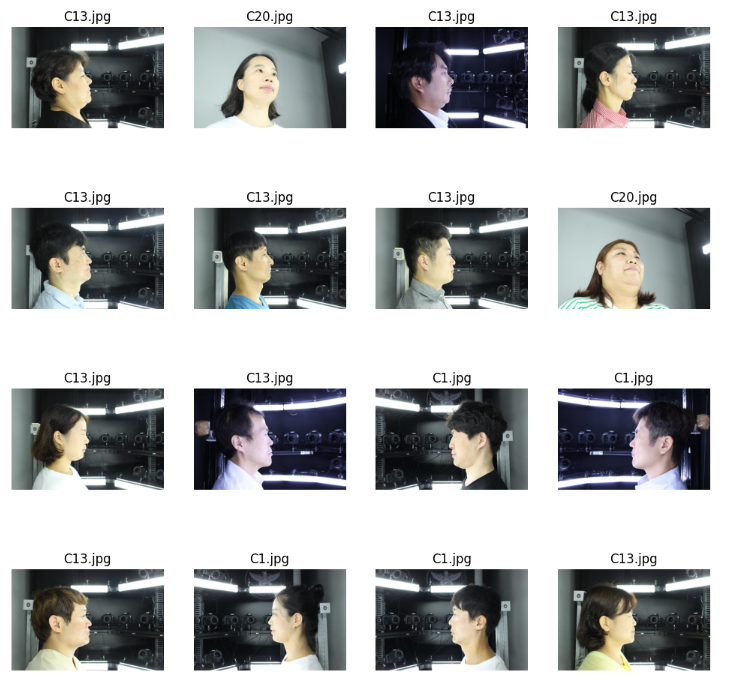

 - 추가적으로 이미 타켓 데이터(얼굴 이미지)만 확보한 상황에서 정밀도나 정확도는 의미가 크지 않음을 발견함
 - 이 경우 얼굴 이미지가 아닌 데이터가 없으므로(GT Negative = 0) 정밀도는 저절로 100%이므로 재현율이 정확도가 됨을 파악함.
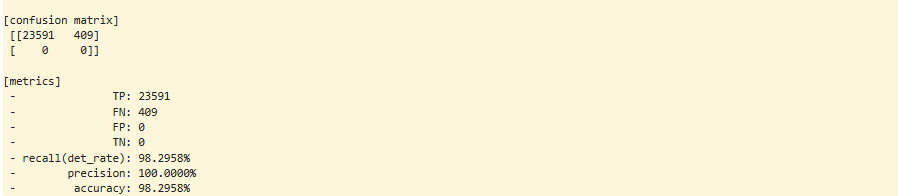
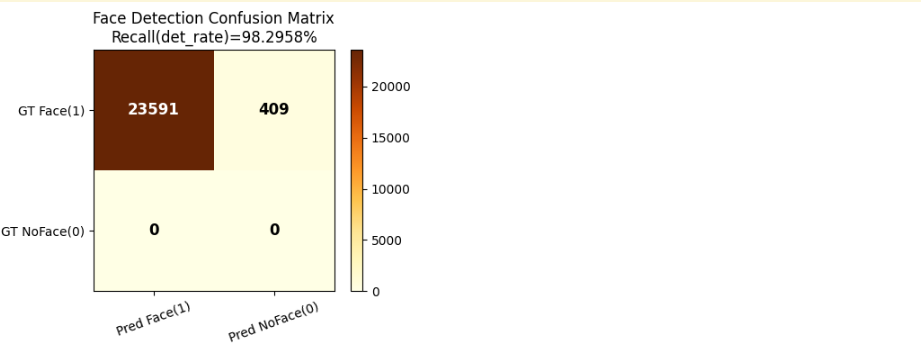
  
##### 개인정보 보호를 위해 눈을 마스킹 처리한 1000명(정면 F, 좌/우 측면 L/R) 데이터 확보
 - 얼굴에서 눈을 마스킹 한 경우라도 정면은 얼굴탐지 성능이 90% 까지 가능하지만, 좌/우 방향은 50%대까지 덜어짐을 확인함
 - 3방향(F/L/R) Face Detection 가능성 및 성능 평가
  - F  0.910448  - L  0.712687
  - R  0.517 2
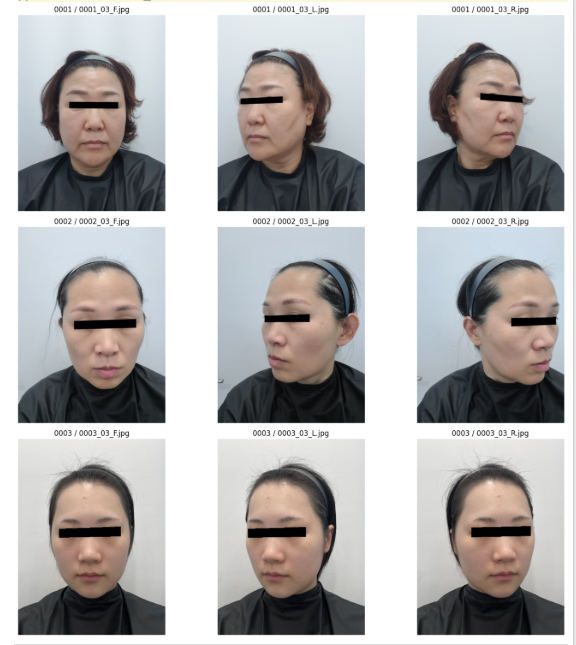

#####  성능 목표(95% 이상) 달성 후 커스텀 모듈 개발
-  모듈화 후 성능 검증: 98% 이상 달성

### 1 K-Face로 Face Detection

In [1]:
# -----------------------------------
# 1) K-Face 데이터 스캔 → df 만들기
# -----------------------------------

from pathlib import Path
import pandas as pd

DATA_ROOT = Path(r"D:\PyProject\datasets\K-Face")
S = "S001"
L = "L1"
EXPRESSIONS = ["E01", "E02", "E03"]   # 보통/웃음/찡그림(눈 감김)

rows = []

# K-Face 아래 person 폴더(예: 19062421)가 몇 개인지 모르니 자동 탐색
for person_dir in sorted(DATA_ROOT.glob("*")):
    if not person_dir.is_dir():
        continue

    person_id = person_dir.name
    l1_dir = person_dir / S / L
    if not l1_dir.exists():
        continue

    for e in EXPRESSIONS:
        e_dir = l1_dir / e
        if not e_dir.exists():
            continue

        # C1.jpg ~ C20.jpg (대/소문자 혹시 몰라서 jpg/JPG 모두)
        imgs = list(e_dir.glob("C*.jpg")) + list(e_dir.glob("C*.JPG"))
        for img_path in imgs:
            cam = img_path.stem  # "C1" ~ "C20"
            rows.append({
                "person_id": person_id,
                "S": S,
                "L": L,
                "expr": e,
                "cam": cam,
                "path": str(img_path),
            })

df = pd.DataFrame(rows)
print("Total images:", len(df))
print("Total persons:", df["person_id"].nunique() if len(df) else 0)
print(df.head())
print("\nCounts by expr:")
print(df["expr"].value_counts().sort_index())
print("\nCounts by cam (top 10):")
print(df["cam"].value_counts().sort_index().head(10))

Total images: 48000
Total persons: 400
  person_id     S   L expr  cam  \
0  19062421  S001  L1  E01   C1   
1  19062421  S001  L1  E01  C10   
2  19062421  S001  L1  E01  C11   
3  19062421  S001  L1  E01  C12   
4  19062421  S001  L1  E01  C13   

                                                path  
0  D:\PyProject\datasets\K-Face\19062421\S001\L1\...  
1  D:\PyProject\datasets\K-Face\19062421\S001\L1\...  
2  D:\PyProject\datasets\K-Face\19062421\S001\L1\...  
3  D:\PyProject\datasets\K-Face\19062421\S001\L1\...  
4  D:\PyProject\datasets\K-Face\19062421\S001\L1\...  

Counts by expr:
expr
E01    16000
E02    16000
E03    16000
Name: count, dtype: int64

Counts by cam (top 10):
cam
C1     2400
C10    2400
C11    2400
C12    2400
C13    2400
C14    2400
C15    2400
C16    2400
C17    2400
C18    2400
Name: count, dtype: int64


In [3]:
# ---------------------------------
# 2) MediaPipe Face Detection 평가
# ---------------------------------
import time
import cv2
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
import mediapipe as mp
from pathlib import Path

WORK_DIR = Path(r"D:\PyProject\AIFFEL_AI\CNN")
OUT_DIR = WORK_DIR / "face_eval_outputs_kface"
OUT_DIR.mkdir(parents=True, exist_ok=True)
print("OUT_DIR:", OUT_DIR)

# --- MediaPipe Face Detection (Baseline) ---
detector = mp.solutions.face_detection.FaceDetection(
    model_selection=1,
    min_detection_confidence=0.5
)

def clamp(v, lo, hi):
    return max(lo, min(hi, v))

# 속도/안정성 옵션: 고해상도면 detector가 불안정/느릴 수 있어 긴 변 리사이즈를 권장
MAX_SIDE = 1280  # None이면 원본 그대로, 1280/960/720 등 조절 가능

def maybe_resize(bgr, max_side=1280):
    if max_side is None:
        return bgr, 1.0
    h, w = bgr.shape[:2]
    m = max(h, w)
    if m <= max_side:
        return bgr, 1.0
    scale = max_side / float(m)
    new_w = int(round(w * scale))
    new_h = int(round(h * scale))
    resized = cv2.resize(bgr, (new_w, new_h), interpolation=cv2.INTER_AREA)
    return resized, scale

records = []
t0_all = time.perf_counter()

for _, row in tqdm(df.iterrows(), total=len(df)):
    img_path = row["path"]
    bgr0 = cv2.imread(img_path)
    if bgr0 is None:
        records.append({**row, "detected": 0, "reason": "imread_fail"})
        continue

    bgr, scale = maybe_resize(bgr0, MAX_SIDE)
    h, w = bgr.shape[:2]
    rgb = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)

    t0 = time.perf_counter()
    out = detector.process(rgb)
    dt = (time.perf_counter() - t0) * 1000.0

    if not out.detections:
        records.append({**row, "w": w, "h": h, "scale": scale,
                        "detected": 0, "time_ms": dt, "reason": "no_face"})
        continue

    # 여러 얼굴이면 가장 큰 bbox 선택 (1명 촬영 가정)
    best, best_area = None, -1.0
    for d in out.detections:
        rb = d.location_data.relative_bounding_box
        x1 = rb.xmin * w
        y1 = rb.ymin * h
        x2 = (rb.xmin + rb.width) * w
        y2 = (rb.ymin + rb.height) * h
        area = max(0.0, x2 - x1) * max(0.0, y2 - y1)
        if area > best_area:
            best_area = area
            best = d

    score = float(best.score[0])
    rb = best.location_data.relative_bounding_box

    x1 = clamp(rb.xmin * w, 0, w - 1)
    y1 = clamp(rb.ymin * h, 0, h - 1)
    x2 = clamp((rb.xmin + rb.width) * w, 0, w - 1)
    y2 = clamp((rb.ymin + rb.height) * h, 0, h - 1)

    bw = max(0.0, x2 - x1)
    bh = max(0.0, y2 - y1)
    area_ratio = (bw * bh) / (w * h + 1e-9)

    records.append({
        **row,
        "w": w, "h": h, "scale": scale,
        "detected": 1,
        "time_ms": dt,
        "det_score": score,
        "x1": x1, "y1": y1, "x2": x2, "y2": y2,
        "area_ratio": float(area_ratio),
        "num_faces": len(out.detections),
        "reason": ""
    })

t_all = time.perf_counter() - t0_all
res = pd.DataFrame(records)

csv_path = OUT_DIR / f"mediapipe_kface_ms{MAX_SIDE if MAX_SIDE else 'orig'}.csv"
res.to_csv(csv_path, index=False, encoding="utf-8-sig")

print("\nSaved:", csv_path)
print(f"Total time: {t_all:.2f}s | avg {(t_all/len(res))*1000:.2f} ms/img")
print("\nDetected rate overall:", float(res["detected"].mean()))

print("\nDetected rate by expr:")
print(res.groupby("expr")["detected"].mean().sort_index())

print("\nDetected rate by cam:")
cam_rate = res.groupby("cam")["detected"].mean().sort_index()
print(cam_rate)

# --- 목표: 95% 이상이 나오는 "최고 조합" 찾기 ---
# (expr, cam) 조합별 검출률
combo = (
    res.groupby(["expr", "cam"])["detected"]
    .mean()
    .reset_index()
    .rename(columns={"detected":"det_rate"})
    .sort_values("det_rate", ascending=False)
)

combo_path = OUT_DIR / "kface_combo_rank.csv"
combo.to_csv(combo_path, index=False, encoding="utf-8-sig")

print("\nSaved combo rank:", combo_path)

top10 = combo.head(10)
print("\nTop-10 (expr, cam) by det_rate:")
print(top10)

good95 = combo[combo["det_rate"] >= 0.95]
print("\nCombos >= 0.95:", len(good95))
if len(good95):
    print(good95.head(30))  # 많으면 앞부분만

OUT_DIR: D:\PyProject\AIFFEL_AI\CNN\face_eval_outputs_kface


  0%|          | 0/48000 [00:00<?, ?it/s]

D:\anaconda3\envs\torch_first\lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '



Saved: D:\PyProject\AIFFEL_AI\CNN\face_eval_outputs_kface\mediapipe_kface_ms1280.csv
Total time: 414.57s | avg 8.64 ms/img

Detected rate overall: 0.9829583333333334

Detected rate by expr:
expr
E01    0.985750
E02    0.988625
E03    0.974500
Name: detected, dtype: float64

Detected rate by cam:
cam
C1     0.891667
C10    0.996667
C11    0.995833
C12    0.993333
C13    0.863333
C14    0.985833
C15    0.999167
C16    0.999167
C17    0.998333
C18    0.977500
C19    0.984167
C2     0.995833
C20    0.984167
C3     0.999167
C4     0.999167
C5     0.998333
C6     0.999167
C7     1.000000
C8     1.000000
C9     0.998333
Name: detected, dtype: float64

Saved combo rank: D:\PyProject\AIFFEL_AI\CNN\face_eval_outputs_kface\kface_combo_rank.csv

Top-10 (expr, cam) by det_rate:
   expr  cam  det_rate
2   E01  C11       1.0
10  E01  C19       1.0
6   E01  C15       1.0
7   E01  C16       1.0
11  E01   C2       1.0
8   E01  C17       1.0
17  E01   C7       1.0
18  E01   C8       1.0
16  E01   C6    

In [4]:
# ------------------------------------------------------
# 3) “95% 이상 조합”에 대해서 실패 샘플만 뽑아보기
# ------------------------------------------------------
import cv2
from pathlib import Path

FAIL_DIR = OUT_DIR / "fail_samples"
FAIL_DIR.mkdir(parents=True, exist_ok=True)

# 예: 최고 조합 1개만 골라서 실패샘플 저장
best_expr = combo.iloc[0]["expr"]
best_cam  = combo.iloc[0]["cam"]

sub = res[(res["expr"] == best_expr) & (res["cam"] == best_cam)]
fail = sub[sub["detected"] == 0]

print("Best combo:", best_expr, best_cam, "sub_n=", len(sub), "fail_n=", len(fail))

for _, r in fail.head(50).iterrows():
    img = cv2.imread(r["path"])
    if img is None:
        continue
    out_path = FAIL_DIR / f"{r['person_id']}_{best_expr}_{best_cam}_FAIL.jpg"
    cv2.imwrite(str(out_path), img)

print("Saved fails to:", FAIL_DIR)


Best combo: E01 C11 sub_n= 800 fail_n= 0
Saved fails to: D:\PyProject\AIFFEL_AI\CNN\face_eval_outputs_kface\fail_samples


In [5]:
# -----------------------------------------------------
# 4) 성능 재현 검증
# -----------------------------------------------------
import pandas as pd

csv_path = r"D:\PyProject\AIFFEL_AI\CNN\face_eval_outputs_kface\mediapipe_kface_ms1280.csv"
res = pd.read_csv(csv_path)

overall = res["detected"].mean()
by_expr = res.groupby("expr")["detected"].mean()
by_cam  = res.groupby("cam")["detected"].mean()

print("overall:", overall)
print("\nby_expr:\n", by_expr)
print("\nby_cam(min 5):\n", by_cam.sort_values().head())


overall: 0.9829583333333334

by_expr:
 expr
E01    0.985750
E02    0.988625
E03    0.974500
Name: detected, dtype: float64

by_cam(min 5):
 cam
C13    0.863333
C1     0.891667
C18    0.977500
C19    0.984167
C20    0.984167
Name: detected, dtype: float64


In [6]:
from pathlib import Path
import shutil
from tqdm import tqdm

fail_df = res[res["detected"] == 0].copy()

print("Fail images:", len(fail_df))

FAIL_DIR = Path(r"D:\PyProject\AIFFEL_AI\CNN\face_eval_outputs_kface\all_fail_samples")
FAIL_DIR.mkdir(parents=True, exist_ok=True)

for _, row in tqdm(fail_df.iterrows(), total=len(fail_df)):
    
    src = Path(row["path"])
    
    # expr_cam 기준으로 폴더 분리
    dst_dir = FAIL_DIR / f"{row['expr']}_{row['cam']}"
    dst_dir.mkdir(exist_ok=True)
    
    dst = dst_dir / src.name
    
    shutil.copy(src, dst)

print("Fail samples saved →", FAIL_DIR)

Fail images: 818


100%|███████████████████████████████████████████████████████████████████████████████| 818/818 [00:01<00:00, 776.82it/s]

Fail samples saved → D:\PyProject\AIFFEL_AI\CNN\face_eval_outputs_kface\all_fail_samples


In [7]:
fail_stats = (
    res.groupby(["expr","cam"])
    .apply(lambda x: 1 - x["detected"].mean())
    .rename("fail_rate")
    .sort_values(ascending=False)
)

print(fail_stats.head(20))

expr  cam
E03   C13    0.1650
      C1     0.1600
E01   C13    0.1525
E02   C13    0.0925
      C1     0.0825
E01   C1     0.0825
E03   C19    0.0425
      C18    0.0300
      C14    0.0250
E01   C18    0.0225
E03   C20    0.0225
      C12    0.0175
E02   C18    0.0150
E01   C20    0.0125
E02   C20    0.0125
E03   C2     0.0125
E01   C14    0.0100
E03   C10    0.0075
      C11    0.0075
E02   C14    0.0075
Name: fail_rate, dtype: float64


C:\Users\hugctx\AppData\Local\Temp\ipykernel_34676\3635737858.py:2: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  res.groupby(["expr","cam"])


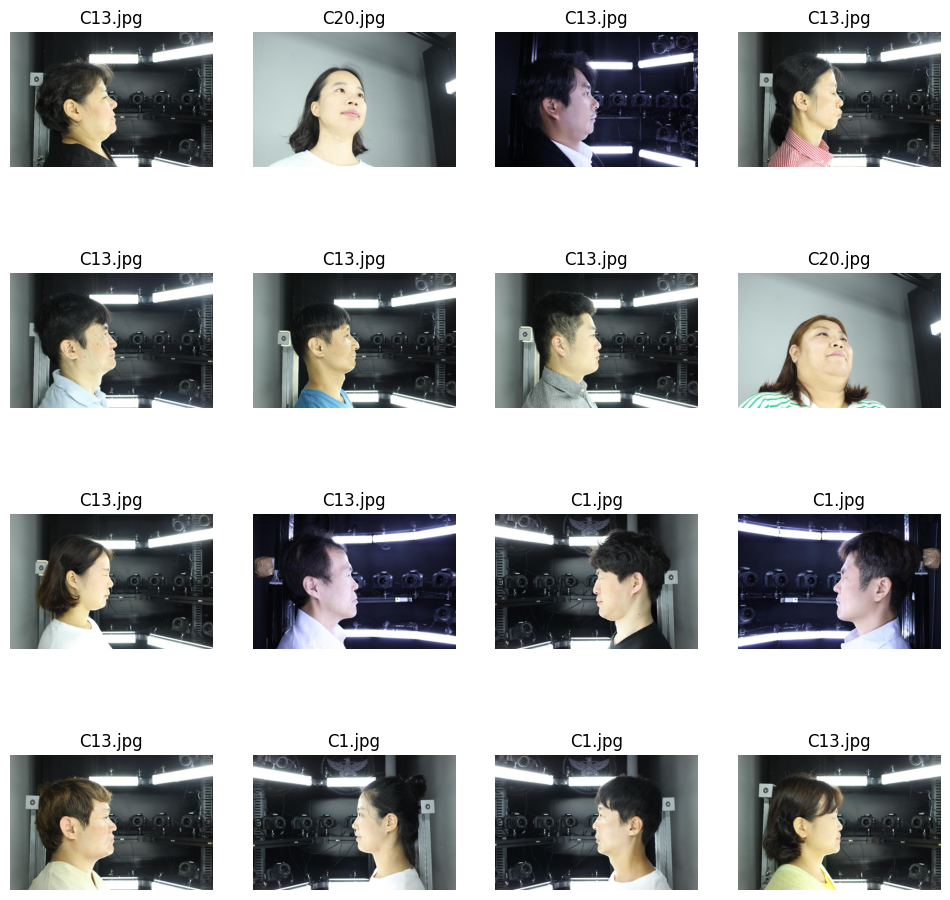

In [8]:
import matplotlib.pyplot as plt
import random
import cv2

sample_paths = fail_df["path"].sample(16).tolist()

plt.figure(figsize=(12,12))

for i, p in enumerate(sample_paths):
    
    img = cv2.imread(p)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    plt.subplot(4,4,i+1)
    plt.imshow(img)
    plt.title(Path(p).name)
    plt.axis("off")

plt.show()

## 2 개인정보 보호 데이터 

WORK_DIR : D:\PyProject\AIFFEL_AI\CNN
DATA_ROOT: D:\PyProject\datasets\skinAI\korea_skin_data\model_and_data\docker_image\skin_dataset\data_and_model\dataset\img\03
Exists?  : True

[1] Found folders: 1072 (e.g. 0001 ~ 1100)

[2] View counts (F/L/R):
  - F: 1072
  - L: 1072
  - R: 1072
  Total valid images: 3216

[3] Image mode counts (RGB/L/etc):
  - RGB: 3216

[4] Top image sizes (W,H):
  - (2208, 2944): 1029
  - (2316, 3088): 645
  - (1980, 2640): 399
  - (2448, 3264): 216
  - (1919, 2560): 132
  - (2544, 3392): 117
  - (1920, 2560): 108
  - (960, 1280): 81
  - (2320, 3088): 75
  - (2736, 3648): 54

[5] Missing expected views: None ✅

[6] Invalid/unreadable files: None ✅


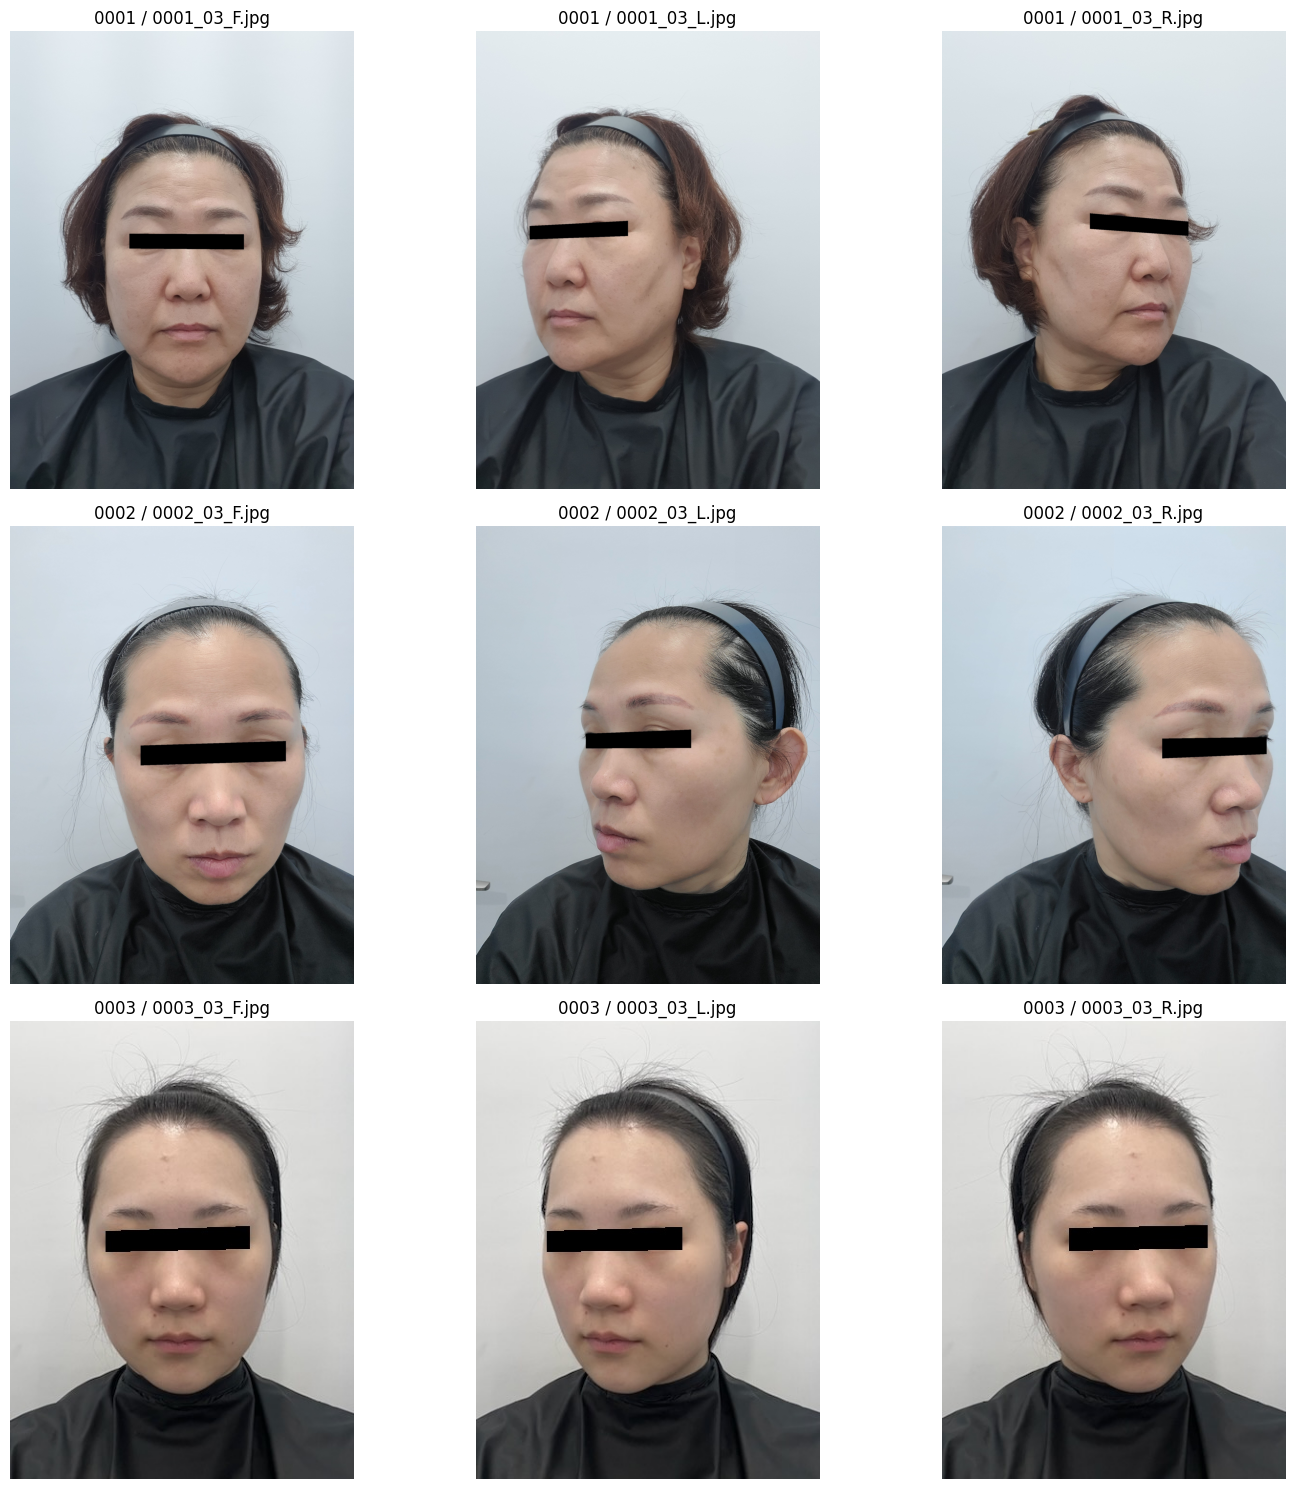

In [9]:
# ============================================================
# Dataset Quick Inspector (F/L/R) - Korea Skin Data
# ============================================================
from pathlib import Path
import re
from collections import Counter, defaultdict

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt


# ---- Paths (수정 가능) ----
WORK_DIR = Path(r"D:\PyProject\AIFFEL_AI\CNN")
DATA_ROOT = Path(r"D:\PyProject\datasets\skinAI\korea_skin_data\model_and_data\docker_image\skin_dataset\data_and_model\dataset\img\03")

print("WORK_DIR :", WORK_DIR)
print("DATA_ROOT:", DATA_ROOT)
print("Exists?  :", DATA_ROOT.exists())


# ---- Settings ----
EXPECTED_VIEWS = ["F", "L", "R"]
# 파일명 예: 0001_03_F.jpg
FNAME_RE = re.compile(r"^(?P<pid>\d{4})_(?P<src>\d{2})_(?P<view>[FLR])\.jpg$", re.IGNORECASE)

# 폴더명 예: 0001
FOLDER_RE = re.compile(r"^\d{4}$")


def scan_dataset(data_root: Path):
    folders = sorted([p for p in data_root.iterdir() if p.is_dir() and FOLDER_RE.match(p.name)])
    print(f"\n[1] Found folders: {len(folders)} (e.g. {folders[0].name if folders else 'N/A'} ~ {folders[-1].name if folders else 'N/A'})")

    view_counter = Counter()
    per_id_views = defaultdict(set)
    invalid_files = []
    missing_expected = []
    size_counter = Counter()
    mode_counter = Counter()

    # 샘플 이미지 경로 몇 개 저장
    sample_paths = []

    for folder in folders:
        pid = folder.name
        imgs = sorted([p for p in folder.glob("*.jpg")])

        # 파일명 검사
        for img_path in imgs:
            m = FNAME_RE.match(img_path.name)
            if not m:
                invalid_files.append(img_path)
                continue

            pid_in_name = m.group("pid")
            src = m.group("src")
            view = m.group("view").upper()

            # (선택) 폴더와 pid 일치 검사
            if pid_in_name != pid:
                invalid_files.append(img_path)
                continue

            per_id_views[pid].add(view)
            view_counter[view] += 1

            # 해상도/모드 통계 (너무 느리면 아래 주석)
            try:
                with Image.open(img_path) as im:
                    size_counter[im.size] += 1  # (W, H)
                    mode_counter[im.mode] += 1  # RGB, L 등
            except Exception as e:
                invalid_files.append(img_path)

        # 기대 뷰(F/L/R) 누락 체크
        missing = [v for v in EXPECTED_VIEWS if v not in per_id_views[pid]]
        if missing:
            missing_expected.append((pid, missing))

        # 샘플로 3장(F/L/R) 중 존재하는 것만 1세트 저장
        for v in EXPECTED_VIEWS:
            cand = folder / f"{pid}_03_{v}.jpg"
            if cand.exists():
                sample_paths.append(cand)
        # 너무 많으면 제한(시각화용)
        if len(sample_paths) > 30:
            sample_paths = sample_paths[:30]

    return {
        "folders": folders,
        "view_counter": view_counter,
        "per_id_views": per_id_views,
        "invalid_files": invalid_files,
        "missing_expected": missing_expected,
        "size_counter": size_counter,
        "mode_counter": mode_counter,
        "sample_paths": sample_paths,
    }


def print_report(result: dict, top_k_sizes=10):
    folders = result["folders"]
    view_counter = result["view_counter"]
    invalid_files = result["invalid_files"]
    missing_expected = result["missing_expected"]
    size_counter = result["size_counter"]
    mode_counter = result["mode_counter"]

    print("\n[2] View counts (F/L/R):")
    for v in EXPECTED_VIEWS:
        print(f"  - {v}: {view_counter.get(v, 0)}")

    total_imgs = sum(view_counter.values())
    print(f"  Total valid images: {total_imgs}")

    print("\n[3] Image mode counts (RGB/L/etc):")
    for mode, cnt in mode_counter.most_common():
        print(f"  - {mode}: {cnt}")

    print("\n[4] Top image sizes (W,H):")
    for (w, h), cnt in size_counter.most_common(top_k_sizes):
        print(f"  - {(w,h)}: {cnt}")

    if missing_expected:
        print(f"\n[5] Missing expected views (first 20): {len(missing_expected)} IDs have missing views")
        for pid, missing in missing_expected[:20]:
            print(f"  - {pid}: missing {missing}")
    else:
        print("\n[5] Missing expected views: None ✅")

    if invalid_files:
        print(f"\n[6] Invalid/unreadable files (first 20): {len(invalid_files)}")
        for p in invalid_files[:20]:
            print(f"  - {p}")
    else:
        print("\n[6] Invalid/unreadable files: None ✅")


def show_samples(sample_paths, n=9):
    sample_paths = sample_paths[:n]
    if not sample_paths:
        print("No samples to show.")
        return

    cols = 3
    rows = (len(sample_paths) + cols - 1) // cols
    plt.figure(figsize=(cols * 5, rows * 5))

    for i, p in enumerate(sample_paths, 1):
        with Image.open(p) as im:
            plt.subplot(rows, cols, i)
            plt.imshow(im)
            plt.axis("off")
            plt.title(p.parent.name + " / " + p.name)

    plt.tight_layout()
    plt.show()


# ---- Run ----
result = scan_dataset(DATA_ROOT)
print_report(result, top_k_sizes=10)
show_samples(result["sample_paths"], n=9)

In [10]:
# Data Frame 생성
from pathlib import Path
import pandas as pd

DATA_ROOT = Path(r"D:\PyProject\datasets\skinAI\korea_skin_data\model_and_data\docker_image\skin_dataset\data_and_model\dataset\img\03")

rows = []

for person_dir in sorted(DATA_ROOT.glob("*")):
    if not person_dir.is_dir():
        continue

    pid = person_dir.name

    for img_path in person_dir.glob("*.jpg"):
        name = img_path.stem  # ex: 0001_03_F
        parts = name.split("_")

        if len(parts) != 3:
            continue

        _, src, view = parts  # pid는 폴더명 사용

        rows.append({
            "pid": pid,
            "src": src,
            "view": view,
            "path": str(img_path)
        })

df = pd.DataFrame(rows)

print("Total images:", len(df))
print(df.head())


Total images: 3216
    pid src view                                               path
0  0001  03    F  D:\PyProject\datasets\skinAI\korea_skin_data\m...
1  0001  03    L  D:\PyProject\datasets\skinAI\korea_skin_data\m...
2  0001  03    R  D:\PyProject\datasets\skinAI\korea_skin_data\m...
3  0002  03    F  D:\PyProject\datasets\skinAI\korea_skin_data\m...
4  0002  03    L  D:\PyProject\datasets\skinAI\korea_skin_data\m...


In [11]:
import time
import cv2
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
from mediapipe.python.solutions import face_detection

# --- output dir ---
OUT_DIR = Path(r"D:\PyProject\AIFFEL_AI\CNN") / "face_eval_outputs"
OUT_DIR.mkdir(parents=True, exist_ok=True)
print("OUT_DIR:", OUT_DIR)

# --- MediaPipe Face Detection (Baseline Configuration) ---
# model_selection:
#   0 → 근거리 얼굴 최적화 (short-range, 약 2m 이내)
#   1 → 중/원거리 얼굴 검출에 유리 (full-range, 고해상도 이미지 대응)
#   본 실험은 모바일 촬영 고해상도 얼굴 데이터이므로 model_selection=1 사용
#
# min_detection_confidence:
#   얼굴로 판단하는 최소 신뢰도 임계값
#   값이 높을수록 오탐(false positive)은 감소하지만 미탐(false negative)은 증가 가능
#   baseline 평가를 위해 0.5 사용 (MediaPipe 기본 권장값)
detector = face_detection.FaceDetection(
    model_selection=1,
    min_detection_confidence=0.5
)

def clamp(v, lo, hi):
    return max(lo, min(hi, v))

records = []
t0_all = time.perf_counter()

for _, row in tqdm(df.iterrows(), total=len(df)):
    img_path = row["path"]
    bgr = cv2.imread(img_path)
    if bgr is None:
        records.append({**row, "detected": 0, "reason": "imread_fail"})
        continue

    h, w = bgr.shape[:2]
    rgb = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)

    t0 = time.perf_counter()
    out = detector.process(rgb)
    dt = (time.perf_counter() - t0) * 1000.0  # ms

    if not out.detections:
        records.append({**row, "w": w, "h": h, "detected": 0, "time_ms": dt, "reason": "no_face"})
        continue

    # 여러 얼굴이면 "가장 큰 bbox" 선택(1명 촬영 가정)
    best, best_area = None, -1.0
    for d in out.detections:
        rb = d.location_data.relative_bounding_box
        x1 = rb.xmin * w
        y1 = rb.ymin * h
        x2 = (rb.xmin + rb.width) * w
        y2 = (rb.xmin + rb.height) * h  # (주의) y2도 height로 계산해야 해서 아래에서 바로잡음
        y2 = (rb.ymin + rb.height) * h
        area = max(0.0, x2 - x1) * max(0.0, y2 - y1)
        if area > best_area:
            best_area = area
            best = d

    score = float(best.score[0])
    rb = best.location_data.relative_bounding_box

    # bbox clamp
    x1 = clamp(rb.xmin * w, 0, w - 1)
    y1 = clamp(rb.ymin * h, 0, h - 1)
    x2 = clamp((rb.xmin + rb.width) * w, 0, w - 1)
    y2 = clamp((rb.ymin + rb.height) * h, 0, h - 1)

    bw = max(0.0, x2 - x1)
    bh = max(0.0, y2 - y1)
    area_ratio = (bw * bh) / (w * h + 1e-9)

    cx, cy = (x1 + x2) / 2.0, (y1 + y2) / 2.0
    dx = (cx - w / 2) / (w / 2 + 1e-9)
    dy = (cy - h / 2) / (h / 2 + 1e-9)
    center_offset = float(np.sqrt(dx * dx + dy * dy))

    records.append({
        **row,
        "w": w, "h": h,
        "detected": 1,
        "time_ms": dt,
        "det_score": score,
        "x1": x1, "y1": y1, "x2": x2, "y2": y2,
        "area_ratio": float(area_ratio),
        "center_offset": center_offset,
        "num_faces": len(out.detections),
        "reason": ""
    })

t_all = time.perf_counter() - t0_all
res = pd.DataFrame(records)

csv_path = OUT_DIR / "mediapipe_results.csv"
res.to_csv(csv_path, index=False, encoding="utf-8-sig")

print("\nSaved:", csv_path)
print(f"Total time: {t_all:.2f}s | avg {(t_all/len(res))*1000:.2f} ms/img")

print("\nDetected rate overall:", float(res["detected"].mean()))
print("\nDetected rate by view:")
print(res.groupby("view")["detected"].mean())

print("\nSpeed (ms/img): mean={:.2f}, p50={:.2f}, p90={:.2f}".format(
    res["time_ms"].mean(),
    res["time_ms"].quantile(0.5),
    res["time_ms"].quantile(0.9),
))

OUT_DIR: D:\PyProject\AIFFEL_AI\CNN\face_eval_outputs


  0%|          | 0/3216 [00:00<?, ?it/s]

D:\anaconda3\envs\torch_first\lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '



Saved: D:\PyProject\AIFFEL_AI\CNN\face_eval_outputs\mediapipe_results.csv
Total time: 155.47s | avg 48.34 ms/img

Detected rate overall: 0.7136194029850746

Detected rate by view:
view
F    0.910448
L    0.712687
R    0.517724
Name: detected, dtype: float64

Speed (ms/img): mean=10.36, p50=10.30, p90=11.81


## 3. Face Detection Custom 모듈 개발 및 테스트

In [12]:
# 모듈 확인
from pathlib import Path
ROOT = Path(r"D:\PyProject\AIFFEL_AI\CNN")
print("face_eval exists:", (ROOT / "face_eval").exists())
print("init exists:", (ROOT / "face_eval" / "__init__.py").exists())
print("files:", [p.name for p in (ROOT / "face_eval").glob("*.py")])

face_eval exists: True
init exists: True
files: ['kface_dataset.py', 'mediapipe_runner.py', 'report.py', '__init__.py']


In [13]:
# 모듈 불러오기
from face_eval.kface_dataset import build_kface_df
from face_eval.mediapipe_runner import run_mediapipe_eval
from face_eval.report import summarize_detection, export_fail_samples

In [14]:
# 모듈로 성능확인
from pathlib import Path

DATA_ROOT = r"D:\PyProject\datasets\K-Face"
OUT_DIR   = Path(r"D:\PyProject\AIFFEL_AI\CNN\face_eval_outputs_kface")
OUT_DIR.mkdir(parents=True, exist_ok=True)

# 1) DF 만들기
df = build_kface_df(DATA_ROOT, s="S001", l="L1")
print("Total images:", len(df))

# 2) 평가 실행 (csv 저장)
res = run_mediapipe_eval(
    df,
    model_selection=1,
    min_detection_confidence=0.5,
    out_csv=str(OUT_DIR / "mediapipe_kface.csv")
)

# 3) 요약(전체/표정/카메라) "전부" 출력 + 파일로 저장
summary = summarize_detection(res)

print("\n[overall]", summary["overall"])

by_expr = summarize_detection(res, ["expr"])["by_group"].sort_values(ascending=False)
by_cam  = summarize_detection(res, ["cam"])["by_group"].sort_values(ascending=False)

print("\n[by_expr] (all)\n", by_expr.to_string())
print("\n[by_cam] (all)\n",  by_cam.to_string())

(by_expr.reset_index()
 .rename(columns={"detected":"det_rate"})
 .to_csv(OUT_DIR / "det_rate_by_expr.csv", index=False, encoding="utf-8-sig"))

(by_cam.reset_index()
 .rename(columns={"detected":"det_rate"})
 .to_csv(OUT_DIR / "det_rate_by_cam.csv", index=False, encoding="utf-8-sig"))

# 4) Fail 이미지 추출(미검출만) + 리스트 저장
fail_dir = OUT_DIR / "fail_samples"
export_fail_samples(
    res,
    out_dir=str(fail_dir),
    n=200000,          # 사실상 전체 fail 다 뽑기 (fail이 1만장 될 일은 없음)
)

print("\nSaved fails to:", fail_dir)
print("Fail count:", int((res["detected"] == 0).sum()))
print("Fail list:", fail_dir / "fail_list.csv")

Total images: 24000


  0%|          | 0/24000 [00:00<?, ?it/s]

D:\anaconda3\envs\torch_first\lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '



[overall] 0.9829583333333334

[by_expr] (all)
 expr
E02    0.988625
E01    0.985750
E03    0.974500

[by_cam] (all)
 cam
C7     1.000000
C8     1.000000
C4     0.999167
C3     0.999167
C15    0.999167
C16    0.999167
C6     0.999167
C17    0.998333
C5     0.998333
C9     0.998333
C10    0.996667
C11    0.995833
C2     0.995833
C12    0.993333
C14    0.985833
C19    0.984167
C20    0.984167
C18    0.977500
C1     0.891667
C13    0.863333

Saved fails to: D:\PyProject\AIFFEL_AI\CNN\face_eval_outputs_kface\fail_samples
Fail count: 409
Fail list: D:\PyProject\AIFFEL_AI\CNN\face_eval_outputs_kface\fail_samples\fail_list.csv
